<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fine-alignment-on-more-GAIA-stars" data-toc-modified-id="Fine-alignment-on-more-GAIA-stars-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fine alignment on more GAIA stars</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import astropy.wcs as pywcs
import astropy.io.fits as pyfits
from skimage.transform import SimilarityTransform

import sep

import tristars.match
from grizli import utils, catalog, prep
import grizli.ds9

gaia = catalog.get_gaia_DR2_vizier(ra=80.8113654, dec=-69.4321433, radius=1.8, 
                                   keys=['ra','dec','pmra','pmdec','RPmag'])


In [2]:
ok = np.isfinite(gaia['pmra'].filled(np.nan) + gaia['pmdec'].filled(np.nan) + gaia['RPmag'].filled(np.nan))
gaia = gaia[ok]
rd = catalog.get_gaia_radec_at_time(gaia, date=2022.3)

gaia['ra_fix'] = rd.ra.deg
gaia['dec_fix'] = rd.dec.deg

so = np.argsort(gaia['RPmag'])
prep.table_to_regions(gaia[so][:200], 'miri_gaia.reg')
len(gaia)


miri_gaia.reg: x = ra, y=dec, ellipse=False


1667

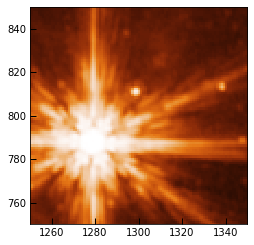

In [31]:


if not os.path.exists('52061788279_3eecae882b_o.png'):
    os.system('wget "https://live.staticflickr.com/65535/52061788279_3eecae882b_o.png"')
    
mir = np.flipud(plt.imread('52061788279_3eecae882b_o.png'))
plt.imshow(mir, origin='lower')
plt.xlim(1250, 1350)
plt.ylim(750, 850)

miri = mir.sum(axis=2)

# First guess based on a single star
hdu = utils.make_wcsheader(ra=80.7866211, dec=-69.4267350, 
                            pixscale=0.11, size=np.array(miri.shape)[::-1]*0.11, 
                            theta=43, get_hdu=True)

hdu.data = miri*1.
hdu.header['CRPIX1'] = 1279
hdu.header['CRPIX2'] = 785

# Shift WCS
wcs = pywcs.WCS(hdu.header)
rd0 = wcs.all_pix2world([1201], [649], 1)
hdu.header['CRPIX1'] = 1201
hdu.header['CRPIX2'] = 649
hdu.header['CRVAl1'] = rd0[0][0]
hdu.header['CRVAL2'] = rd0[1][0]
wcs = pywcs.WCS(hdu.header)

ds9 = grizli.ds9.DS9()
ds9.frame(3)
ds9.view(hdu)

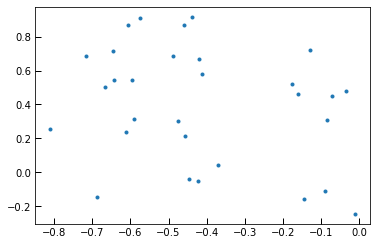

In [32]:
# manual positions of bright gaia stars clicked on DS9
xy_str = """# xm ym
1166.1603 142.40279
1157.8991 186.69994
1228.0502 200.18726
1202.7639 318.42471
1077.6183 305.60137
939.18453 190.53513
938.71526 461.96936
945.123 436.90125
967.9275 462.29738
979.03702 476.77431
1029.3747 521.03664
1038.038 587.95437
1148.8459 703.72493
1164.535 727.95011
1183.0581 711.04158
1277.0096 789.18402
1377.8657 408.61301
1470.5457 511.56247
1438.6644 551.57006
1533.142 686.29649
1415.3444 370.32915
1254.7012 473.1703
1412.0759 1015.348
1456.2318 1015.5313
1247.0426 956.48315
1022.5031 722.21223
1181.9972 1015.5996
909.09925 806.61691
987.66513 1017.8774
1522.2248 1080.5369"""

xy = utils.read_catalog(xy_str)
xy['x'] = 0.
xy['y'] = 0

# Centroid
R = 5
yp, xp = np.indices(miri.shape)
for i, (xi, yi) in enumerate(zip(xy['xm']-1, xy['ym']-1)):
    mask = np.sqrt((yp-yi)**2 + (xp-xi)**2) < R
    xc = (miri*xp)[mask].sum() / miri[mask].sum()
    yc = (miri*yp)[mask].sum() / miri[mask].sum()
    xy['x'][i] = xc
    xy['y'][i] = yc
    
xy['ra'], xy['dec'] = wcs.all_pix2world(xy['x'], xy['y'], 0)
idx, dr, dx, dy = utils.GTable(gaia).match_to_catalog_sky(xy, self_radec=('ra_fix', 'dec_fix'), 
                                                          get_2d_offset=True)

plt.scatter(dx, dy)
gmat = gaia[idx]

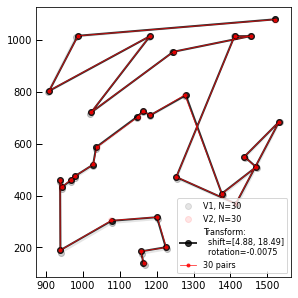

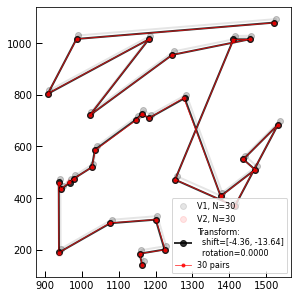

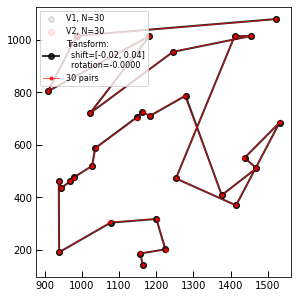

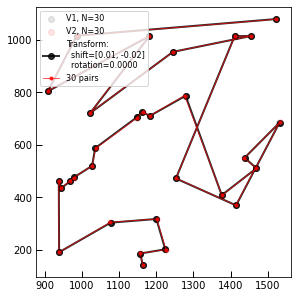

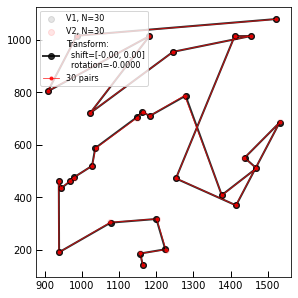

In [33]:
V2 = np.array([xy['x'], xy['y']]).T

for iter in range(5):
    gmat['x'], gmat['y'] = wcs.all_world2pix(gmat['ra_fix'], gmat['dec_fix'], 0)

    V1 = np.array([gmat['x'], gmat['y']]).T

    pair_ix = np.array([(i, i) for i in range(len(xy))])

    tf, dx, rms = tristars.match.get_transform(V1, V2, pair_ix, transform=SimilarityTransform, use_ransac=True)

    fig = tristars.match.match_diagnostic_plot(V1, V2, pair_ix, tf=tf,
                                               new_figure=True)

    wcs = utils.transform_wcs(wcs, tf.translation, tf.rotation, tf.scale)



# Fine alignment on more GAIA stars

Run a source-detection catalog

make_SEP_catalog_from_arrays: sep version = 1.2.0
356 222


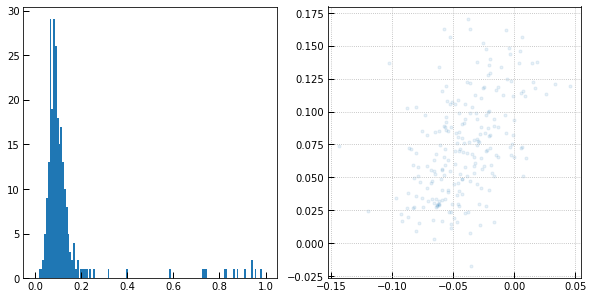

In [34]:
valid = (xp > 874) & (yp > 130) & (xp < 1535) & (yp < 1136)
mask = (~valid)
# plt.imshow(valid)
bkg = sep.Background(hdu.data, mask=mask)

cat, seg = prep.make_SEP_catalog_from_arrays(hdu.data - bkg.back(), bkg.rms(), mask, wcs=wcs, threshold=5, ZP=25)

idx, dr, dx, dy = utils.GTable(gaia).match_to_catalog_sky(cat, self_radec=('ra_fix', 'dec_fix'), 
                                                          get_2d_offset=True)

fig, axes = plt.subplots(1,2,figsize=(10,5))

h = axes[0].hist(dr.value, bins=np.linspace(0,1,128))
hasm = np.abs(dx.value - np.median(dx.value)) < 0.1
hasm &= np.abs(dy.value - np.median(dy.value)) < 0.1

print(len(cat), hasm.sum())

axes[1].scatter(dx[hasm], dy[hasm], alpha=0.1)
axes[1].grid()


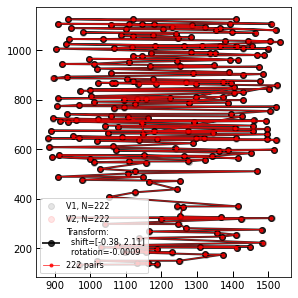

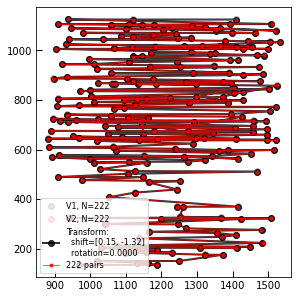

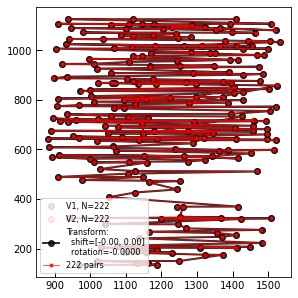

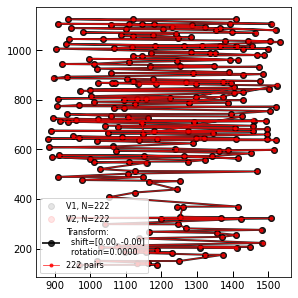

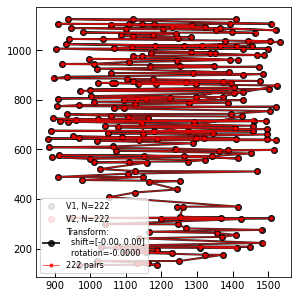

In [35]:
gm2 = gaia[idx][hasm]

V2 = np.array([cat['x'][hasm], cat['y'][hasm]]).T
pair_ix = np.array([(i, i) for i in range(hasm.sum())])

for iter in range(5):
    gm2['x'], gm2['y'] = wcs.all_world2pix(gm2['ra_fix'], gm2['dec_fix'], 0)

    V1 = np.array([gm2['x'], gm2['y']]).T

    tf, dx, rms = tristars.match.get_transform(V1, V2, pair_ix, transform=SimilarityTransform, use_ransac=True)

    fig = tristars.match.match_diagnostic_plot(V1, V2, pair_ix, tf=tf,
                                               new_figure=True)

    wcs = utils.transform_wcs(wcs, tf.translation, tf.rotation, tf.scale)



make_SEP_catalog_from_arrays: sep version = 1.2.0
504 257


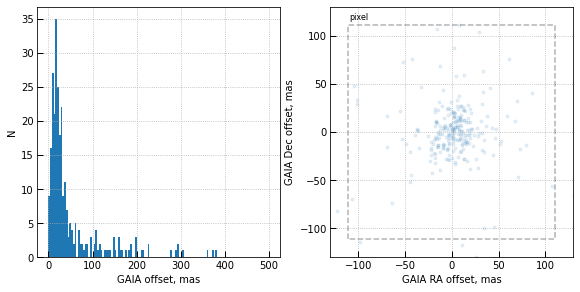

In [37]:
valid = (xp > 874) & (yp > 130) & (xp < 1535) & (yp < 1136)
mask = (~valid)
# plt.imshow(valid)
bkg = sep.Background(hdu.data, mask=mask)

cat, seg = prep.make_SEP_catalog_from_arrays(hdu.data - bkg.back(), bkg.rms(), mask, wcs=wcs, threshold=3, ZP=25)

idx, dr, dx, dy = utils.GTable(gaia).match_to_catalog_sky(cat, self_radec=('ra_fix', 'dec_fix'), 
                                                          get_2d_offset=True)

fig, axes = plt.subplots(1,2,figsize=(8,4))

h = axes[0].hist(dr.value*1000, bins=np.linspace(0,0.5*1000,128))
hasm = np.abs(dx.value - np.median(dx.value)) < 0.15
hasm &= np.abs(dy.value - np.median(dy.value)) < 0.15

xbox = np.array([-0.5, -0.5, 0.5, 0.5, -0.5])*2*pscale*1000
ybox = np.array([-0.5, 0.5, 0.5, -0.5, -0.5])*2*pscale*1000

print(len(cat), hasm.sum())

axes[0].set_xlabel('GAIA offset, mas')
axes[0].set_ylabel('N')

axes[1].plot(xbox, ybox, label='pixel', color='k', alpha=0.3, linestyle='--')
axes[1].set_xlim(-130, 130)
axes[1].set_ylim(*axes[1].get_xlim())
axes[1].text(-110, 115, 'pixel', ha='left', va='bottom', fontsize=8)

axes[1].scatter(dx[hasm]*1000, dy[hasm]*1000, alpha=0.1)
axes[1].set_xlabel('GAIA RA offset, mas')
axes[1].set_ylabel('GAIA Dec offset, mas')

#axes[1].legend()
for ax in axes:
    ax.grid()

fig.tight_layout(pad=0.5)
fig.savefig('miri_lmc_eers_alignment.png')

In [9]:
wcsh = utils.to_header(wcs)
pscale = utils.get_wcs_pscale(wcsh)

hdu.header['PIXASEC'] = pscale

for k in wcsh:
    if k in hdu.header:
        hdu.header[k] = wcsh[k]
    else:
        pass
    #print('Skip ', k)

hdu.header['FILTER'] = 'F770W'
hdu.header['INSTRUME'] = 'MIRI'
hdu.header['TELESCOP'] = 'JWST'

ds9.frame(4)
ds9.view(hdu)

pyfits.PrimaryHDU(data=hdu.data, header=hdu.header).writeto('miri_lmc_eers.fits', 
                                                            overwrite=True, output_verify='fix')

im = pyfits.open('miri_lmc_eers.fits')
im[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1658                                                  
NAXIS2  =                 1265                                                  
CRPIX1  =               1201.0                                                  
CRPIX2  =                649.0                                                  
CRVAL1  =      80.799996678621                                                  
CRVAL2  =     -69.428264722611                                                  
CD1_1   = -2.2699719928993E-05                                                  
CD1_2   = -2.0815421021585E-05                                                  
CD2_1   = -2.0815421021585E-05                                                  
CD2_2   =  2.2699719928994E-